In [ ]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *

# Chapter 7. Collaborative Filtering Deep Dive

**Problem:** Recommending items (movies, products, etc.) to users based on their past behavior and similar users' preferences.

**Solution:** Collaborative filtering

* Identify users with similar tastes based on their past interactions with items.
* Recommend items that those similar users have interacted with.

**Example:** Netflix recommending sci-fi action movies from the 1970s based on a user's watch history, even without explicitly knowing these genres.

**Latent Factors:** Underlying concepts that influence user preferences but might not be explicitly represented in the data (e.g., genre, style, etc.).


#### Lets take a look at the data
**Data:** [MovieLens dataset](https://grouplens.org/datasets/movielens/) with movie ratings used for this example (subset of 100,000 ratings). Full dataset (25 million) available for further exploration.


In [1]:

from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

In [2]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596



* The above data format is not ideal for human comprehension.
* A crosstabulation (human-friendly table) provides a better way to visualize the data.
* 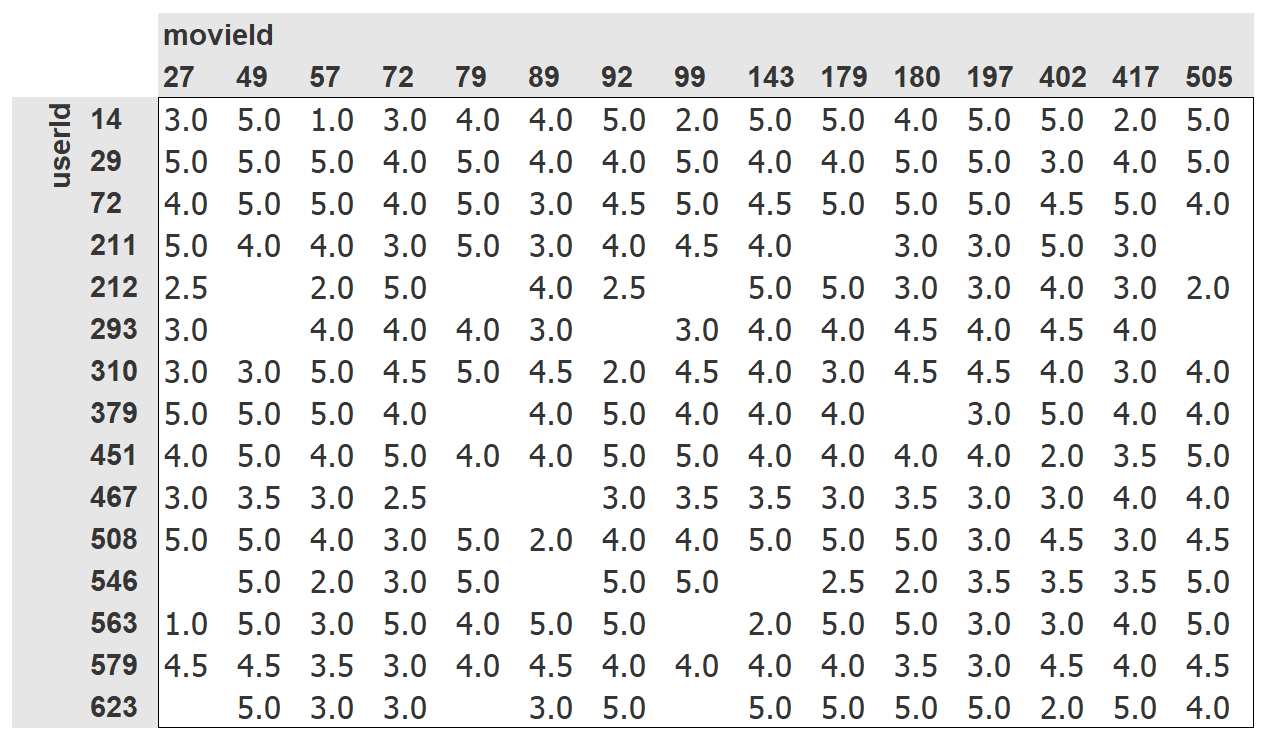
* The crosstab shows movie-user interactions, with empty cells representing unwatched/unreviewed movies.
* The goal is to predict these missing values (user's potential movie enjoyment).
* Predicting user preferences involves understanding user and movie characteristics (genre, director, etc.).
* A potential approach involves multiplying user and movie feature vectors to estimate movie-user compatibility.

Example: 
* The example suggests using a scale of -1 (weak match) to +1 (strong match) for user/movie features.
* The example mentions "[science-fiction, action, old movies]" as potential movie categories.

```py
last_skywalker = np.array([0.98,0.9,-0.9])
```
Above, for instance, we are scoring very science-fiction as 0.98, very action as 0.9, and very not old as -0.9. 

- We could represent a user who likes modern sci-fi action movies as:
```py
user1 = np.array([0.9,0.8,-0.6])
```

To find the match between these combinations (using dot product):

In [3]:
last_skywalker = np.array([0.98,0.9,-0.9])
user1 = np.array([0.9,0.8,-0.6])    
(user1*last_skywalker).sum()

2.1420000000000003

On the other hand, we might represent the movie Casablanca as:

```py
casablanca = np.array([-0.99,-0.3,0.8])
  ```   
The match between this combination is:

In [4]:
casablanca = np.array([-0.99,-0.3,0.8])
(user1*casablanca).sum()

-1.611

Now, lets learn about latent factors and better way to rate the users & movies. 

### Learning Latent Factors for Recommendation Systems:
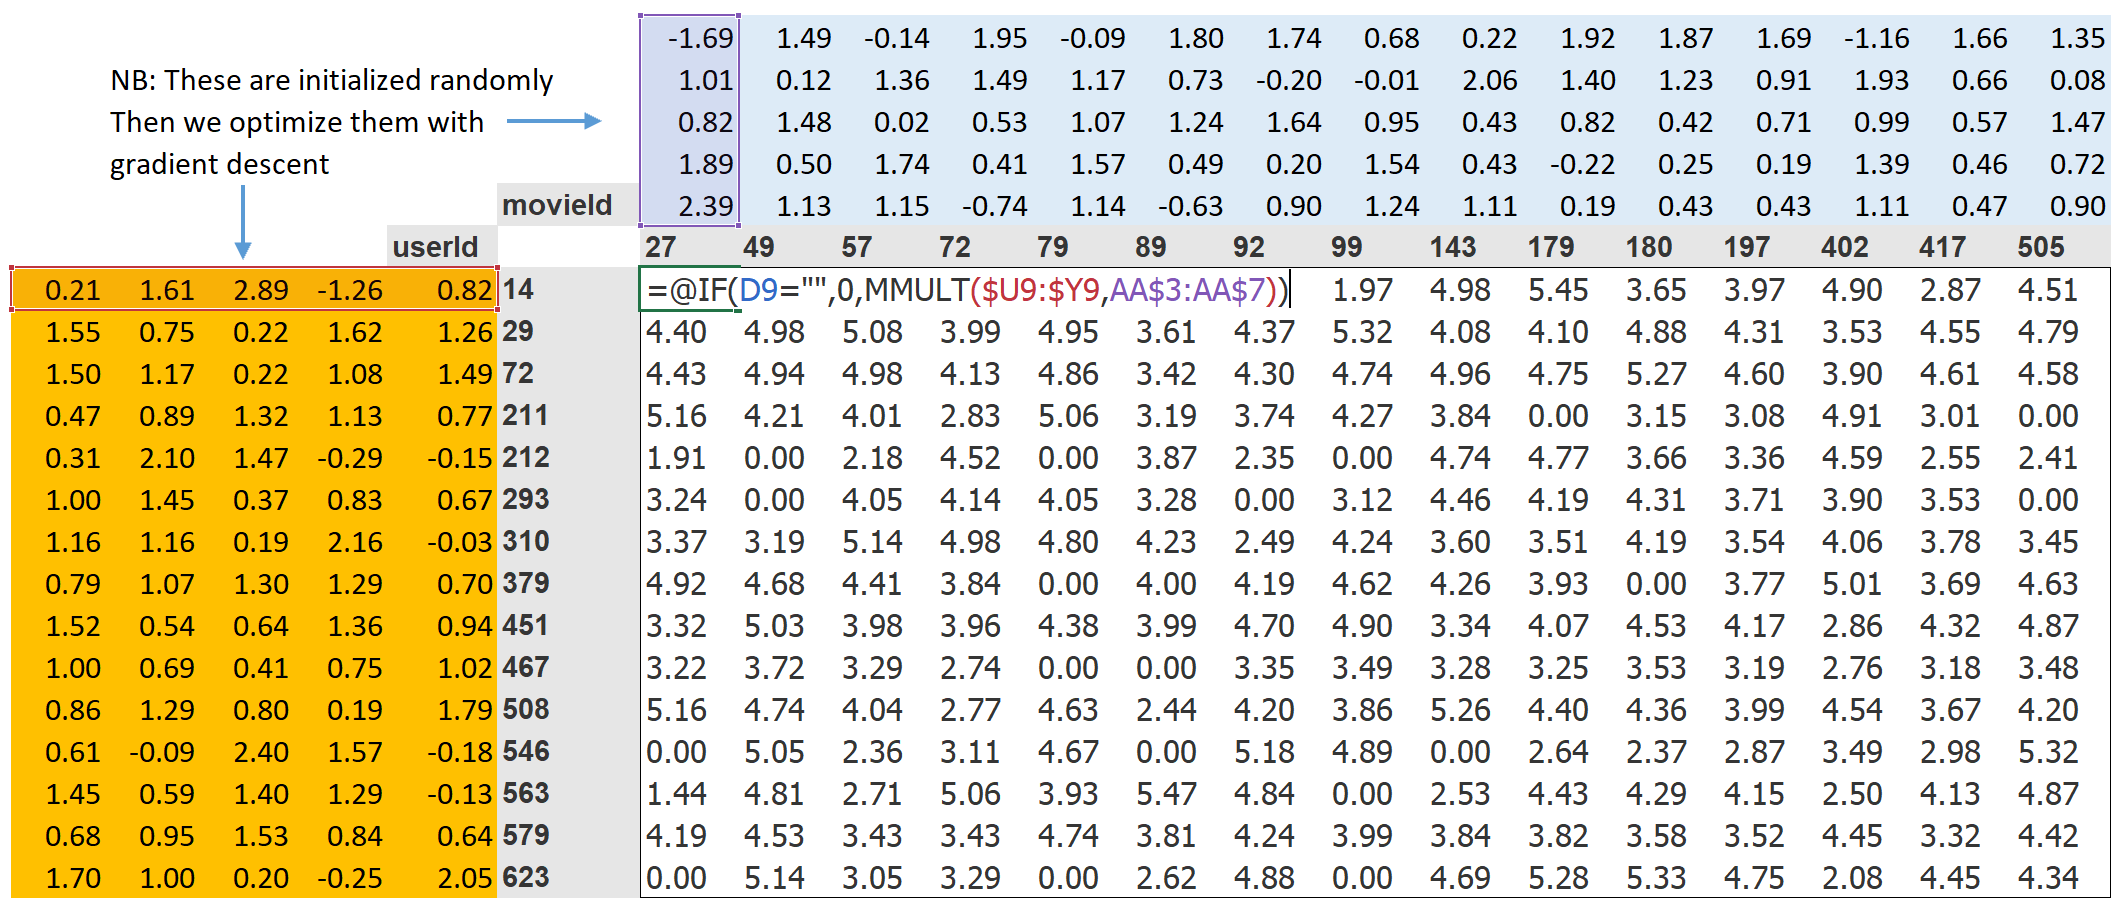



* **Similar to Model Specification:** Learning latent factors is similar to explicitly defining a model structure, but uses gradient descent instead.
* **Random Initialization:** The process starts with randomly assigning latent factors (preferences) to users and movies (characteristics).
* **Number of Latent Factors:** The optimal number of factors needs to be determined (discussed later).
* **Calculating Predictions:** User-movie compatibility is estimated using the dot product of their latent factors.
* **Interpretation:** A high dot product indicates a good match (e.g., user enjoys action and movie has high action content).
* **Loss Function:** Mean squared error is used here to measure prediction accuracy.
* **Optimization:** Stochastic gradient descent is used to minimize the loss by adjusting the latent factors.
* **Learner.fit Integration:** Requires data to be formatted as DataLoaders for training.

**Next Steps:**

* Determining the optimal number of latent factors.
* Implementing data loading for training with Learner.fit.


### Creating the DataLoaders
When showing the data, we would rather see movie titles than their IDs. The table u.item contains the correspondence of IDs to titles:

In [5]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [7]:
# We can merge this with our ratings table to get the user ratings by title:

ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [8]:
"""
We can then build a DataLoaders object from this table. By default, it takes the first column for the user, 
the second column for the item (here our movies), and the third column for the ratings. We need to change the value of 
item_name in our case to use the titles instead of the IDs:
"""

dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,666,Feeling Minnesota (1996),3
1,234,"Boot, Das (1981)",5
2,592,Secrets & Lies (1996),5
3,871,Somewhere in Time (1980),3
4,1,Get Shorty (1995),3
5,59,"Young Poisoner's Handbook, The (1995)",3
6,659,Fried Green Tomatoes (1991),3
7,151,Roman Holiday (1953),5
8,326,Toy Story (1995),3
9,677,Beavis and Butt-head Do America (1996),5


To represent collaborative filtering in PyTorch, we can represent movies and user latent factor tables as simple matrices.

In [9]:
dls.classes

{'user': ['#na#', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 

In [11]:
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

To find the user and movie compbination, 
- we have to look for the index of movie and user in movie latent factor and user latent factor respectively. 
- Once we have the indexes, we perform dot product between these two latent factors

Our models dont know how to look for index in the latent factor. However they know about matrix multiplication and activation functions. 

We can now, represent the look up as a matrix product. The trick is to replace our indices with one-hot encoded vectors. 

In [12]:
one_hot_3 = one_hot(3,n_users).float()
user_factors.t() @ one_hot_3

tensor([-0.3729, -1.1163,  0.3216,  0.8330,  0.1863])

In [13]:
user_factors[3]

tensor([-0.3729, -1.1163,  0.3216,  0.8330,  0.1863])

We observe that the values are matching. So, if we do similar operations (matrix multiplication) for a few indices, we will obtain a matrix of one-hot encoded vectors. 

**Embedding and One-Hot Encoding in Deep Learning**

- **One-Hot Encoding**:
  - Represents categorical data as binary vectors.
  - Each category is a vector where only one element is `1` and all others are `0`.
  - Example: For categories `[A, B, C]`, `A` is represented as `[1, 0, 0]`, `B` as `[0, 1, 0]`, and `C` as `[0, 0, 1]`.

- **Matrix of One-Hot Encoded Vectors**:
  - Combining multiple one-hot-encoded vectors forms a matrix.
  - Multiplying this matrix with another matrix can simulate certain model behaviors.
  - However, this method is inefficient in terms of memory and computational time.

- **Inefficiency of One-Hot Encoding**:
  - Storing large one-hot-encoded vectors is memory-intensive.
  - Searching through one-hot-encoded vectors is computationally expensive.

- **Direct Indexing with Integers**:
  - More efficient to use integers to directly index into an array.
  - Avoids unnecessary memory usage and computation associated with one-hot encoding.

- **Embeddings**:
  - Special layers in deep learning frameworks (like PyTorch) that use integer indexing.
  - Embeddings can capture complex relationships between categories.
  - Simulate the effect of matrix multiplication with one-hot vectors without actually doing it.
  - Compute derivatives as if matrix multiplication was performed, ensuring gradient calculations are correct during backpropagation.

- **Advantages of Embeddings**:
  - Significantly reduce memory usage.
  - Improve computational efficiency.
  - Maintain accurate gradient calculations for learning.

Embeddings provide an efficient way to handle categorical data in deep learning models by avoiding the direct use of one-hot encoding, thus optimizing memory and computational resources while maintaining accurate model training.


**Computer Vision and Embeddings in Recommender Systems**

1. **Pixel Information via RGB Values in Computer Vision**:
   - Each pixel in a colored image is represented by three numbers: R (Red), G (Green), and B (Blue).
   - These values provide the necessary information about the color of the pixel.

2. **Challenges in Characterizing Users and Movies**:
   - Unlike pixels, users and movies don't have straightforward numerical representations.
   - Factors influencing a user's preference may include movie genres, action versus dialogue-heavy content, and favorite actors.

3. **Model Learning Features**:
   - Instead of manually determining numbers to characterize users and movies, we let the model learn these features.
   - The model analyzes the relationships between users and movies to identify important features.

4. **Embeddings**:
   - **Definition**: Embeddings are vectors that represent users and movies.
   - **Initialization**: Each user and movie is assigned a random vector of a certain length (e.g., `n_factors=5`).
   - **Learnable Parameters**: These vectors are learnable parameters that get updated during training.

5. **Training Process**:
   - **Loss Calculation**: The model computes the loss by comparing predictions to actual targets.
   - **Gradient Computation**: Gradients of the loss with respect to the embedding vectors are calculated.
   - **Parameter Update**: Embedding vectors are updated using Stochastic Gradient Descent (SGD) or another optimizer.

6. **Random Initialization**:
   - Initially, embedding vectors are random and meaningless.
   - Through training, these vectors learn to capture meaningful features based on the data.

7. **Outcome of Training**:
   - The learned embeddings can distinguish between different types of movies, such as blockbusters versus independent films, and action movies versus romance.

8. **Model Creation**:
   - With the understanding of embeddings and the learning process, we can create a recommender model from scratch.


In computer vision, pixels are easily characterized by their RGB values. However, users and movies in recommender systems require a model to learn their features. This is achieved through embeddings, which are initially random vectors that get updated during training. These embeddings eventually capture meaningful features and can differentiate between various types of content.

### Collaborative Filtering from Scratch
Before we can write a model in PyTorch, we first need to learn the basics of object-oriented programming and Python. If you haven't done any object-oriented programming before, we will give you a quick introduction here, but we would recommend looking up a tutorial and getting some practice before moving on.

**Object-Oriented Programming (OOP) in Python**

* **Class:** A blueprint for creating objects. Defines properties (attributes) and functionalities (methods) of objects.
* **Example Class:** `Example(a)` demonstrates:
    * `__init__(self, a)`: Special method called during object creation (initialization).
        * `self`: Refers to the current object instance.
        * Initializes an attribute `a` with the provided value.
    * `say(self, x)`: Method that defines the object's behavior (printing a greeting).


In [14]:

class Example:
    def __init__(self, a): self.a = a
    def say(self,x): return f'Hello {self.a}, {x}.'

In [15]:

ex = Example('Sylvain')
ex.say('nice to meet you')

'Hello Sylvain, nice to meet you.'


**Creating PyTorch Modules:**

* Inherit from `nn.Module`: Leverages existing functionalities from PyTorch's `nn` module.
* `forward(self, x)`: Special method called when the module is executed.
    * Receives input data (`x`) and performs the desired computation.

In [17]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
    
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim = 1)
    

"""
Note that the input of the model is a tensor of shape batch_size x 2, where 
the first column (x[:, 0]) contains the user IDs and 
the second column (x[:, 1]) contains the movie IDs. 
As explained before, we use the embedding layers to represent our matrices of user and movie latent factors:
"""


x,y = dls.one_batch()
x.shape

torch.Size([64, 2])

Now that we have defined our architecture, and created our parameter matrices, we need to create a `Learner` to optimize our model. In the past we have used special functions, such as `vision_learner`, which set up everything for us for a particular application. Since we are doing things from scratch here, we will use the plain Learner class:

In [18]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.359286,1.287892,00:11
1,1.085815,1.112101,00:09
2,0.924469,1.001400,00:10
3,0.830754,0.905709,00:09
4,0.783028,0.890568,00:08


1. **Improving Model Predictions:**
   - To enhance the model, constrain the predictions within a specific range.
   - Use `sigmoid_range` for this purpose.
     - Sigmoid function can be adjusted to output within a desired range.

2. **Empirical Findings:**
   - Empirical studies suggest better performance with a slightly extended range.
   - Instead of (0, 5), use (0, 5.5) for the sigmoid function.

3. **Practical Implementation:**
   - Implementing a range of (0, 5.5) ensures predictions stay within realistic bounds while providing a slight buffer over the maximum value of 5. 


In [21]:
 

class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [22]:

model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.997853,0.999754,00:10
1,0.893420,0.916516,00:09
2,0.680387,0.879405,00:09
3,0.490490,0.883300,00:09
4,0.372045,0.886954,00:09


We see, the validation loss was upto 4 epoch, but in 5th epoch the it has increased. This denotes overfitting. So, instead of using data augmentation, we will use another regularization technique. We can try *weight decay*.

### Weight Decay (L2 Regularization)

**Concept:** Weight decay (L2 regularization) adds the sum of squared weights to the loss function during training.

**Purpose:** Encourages smaller weights, reducing model complexity and preventing overfitting.

**Why it works:**

* Larger weights create steeper slopes in the loss function (like a narrow parabola).
* Weight decay penalizes these large slopes, pushing weights towards smaller values.
* Smaller weights lead to a smoother, more generalizable model, less prone to overfitting on specific training data.

**Analogy:** Imagine a landscape with hills and valleys representing the loss function. Weight decay discourages steep cliffs (large weights) and encourages gentle slopes (smaller weights), making the model more adaptable to unseen data.


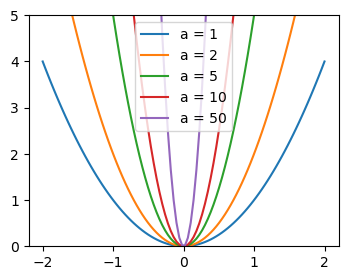

In [28]:
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50]
ys = [a*x**2 for a in a_s]
_,ax = plt.subplots(figsize = (4,3))
for a ,y in zip(a_s, ys):
    ax.plot(x,y,label = f'a = {a}')
ax.set_ylim([0,5])
ax.legend()

So, when we let our model learn high parameters, it might start overfitting. the more parameters it has, the more 